In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch.utils.data as Data
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [3]:
df=pd.read_csv("/content/drive/MyDrive/covid_19/covid_19/covid_19_data.csv")
print(df)

           SNo ObservationDate     Province/State  ... Confirmed  Deaths  Recovered
0            1      01/22/2020              Anhui  ...       1.0     0.0        0.0
1            2      01/22/2020            Beijing  ...      14.0     0.0        0.0
2            3      01/22/2020          Chongqing  ...       6.0     0.0        0.0
3            4      01/22/2020             Fujian  ...       1.0     0.0        0.0
4            5      01/22/2020              Gansu  ...       0.0     0.0        0.0
...        ...             ...                ...  ...       ...     ...        ...
306424  306425      05/29/2021  Zaporizhia Oblast  ...  102641.0  2335.0    95289.0
306425  306426      05/29/2021            Zeeland  ...   29147.0   245.0        0.0
306426  306427      05/29/2021           Zhejiang  ...    1364.0     1.0     1324.0
306427  306428      05/29/2021    Zhytomyr Oblast  ...   87550.0  1738.0    83790.0
306428  306429      05/29/2021       Zuid-Holland  ...  391559.0  4252.0    

In [6]:
dataset_rnn = df.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
dataset_rnn

,Confirmed,Recovered,Deaths
ObservationDate,,,
01/01/2021,84092619.0,47313005.0,1834675.0
01/02/2021,84718978.0,47614297.0,1843108.0
01/03/2021,85251774.0,47882779.0,1850449.0
01/04/2021,85805892.0,48173187.0,1860598.0
01/05/2021,86546014.0,48488548.0,1875953.0
...,...,...,...
12/27/2020,80912611.0,45717710.0,1771659.0
12/28/2020,81408934.0,46016136.0,1781415.0
12/29/2020,82073362.0,46369231.0,1796786.0


In [8]:
confirmed_rnn = dataset_rnn.drop(['Recovered','Deaths'],axis=1)
confirmed_rnn

,Confirmed
ObservationDate,
01/01/2021,84092619.0
01/02/2021,84718978.0
01/03/2021,85251774.0
01/04/2021,85805892.0
01/05/2021,86546014.0
...,...
12/27/2020,80912611.0
12/28/2020,81408934.0
12/29/2020,82073362.0


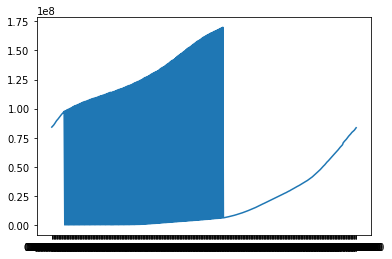

In [19]:
plt.plot(confirmed_rnn)

In [9]:
confirmed_rnn = confirmed_rnn.dropna()
dataset = confirmed_rnn.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [10]:
print(dataset)

[array([0.4948051], dtype=float32), array([0.49849063], dtype=float32), array([0.50162566], dtype=float32), array([0.5048861], dtype=float32), array([0.50924104], dtype=float32), array([0.5138504], dtype=float32), array([0.5190333], dtype=float32), array([0.5237595], dtype=float32), array([0.5282372], dtype=float32), array([0.5317037], dtype=float32), array([0.5353514], dtype=float32), array([0.5395026], dtype=float32), array([0.5439062], dtype=float32), array([0.54835], dtype=float32), array([0.5528642], dtype=float32), array([0.55662495], dtype=float32), array([0.5597388], dtype=float32), array([0.5627695], dtype=float32), array([0.5663495], dtype=float32), array([0.5704268], dtype=float32), array([0.5742886], dtype=float32), array([3.2774153e-06], dtype=float32), array([0.5781666], dtype=float32), array([6.454802e-06], dtype=float32), array([0.5815094], dtype=float32), array([5.5368905e-06], dtype=float32), array([0.5841317], dtype=float32), array([8.4553785e-06], dtype=float32), ar

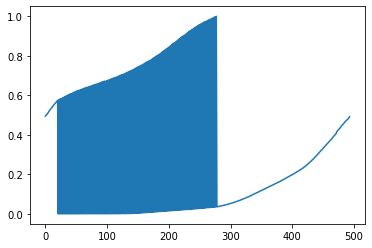

In [20]:
plt.plot(dataset)

In [11]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [12]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [13]:
# 划分訓練集和測試集，70% 作为訓練集 ，30% 作为測試集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [14]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [15]:
from torch import nn
from torch.autograd import Variable

In [16]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归

    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [17]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [28]:
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.4f}'.format(e + 1, loss.data))

Epoch: 100, Loss: 0.0051
Epoch: 200, Loss: 0.0049
Epoch: 300, Loss: 0.0045
Epoch: 400, Loss: 0.0057
Epoch: 500, Loss: 0.0056
Epoch: 600, Loss: 0.0056
Epoch: 700, Loss: 0.0055
Epoch: 800, Loss: 0.0055
Epoch: 900, Loss: 0.0054
Epoch: 1000, Loss: 0.0053


In [29]:
net = net.eval() # 转换成测试模式

In [30]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [31]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

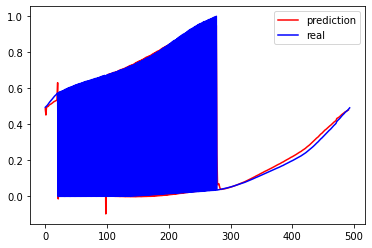

In [32]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')